In [1]:
%matplotlib inline

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python

In [3]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# 1. LeNet Architecture with BatchNorm


In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weight in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

In [5]:
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weight in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

# 2. Display the Network

In [6]:
lenet_model = LeNet()
print(lenet_model)
lenetBN_model = LeNetBN()
print(lenetBN_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Bat

# 3. Get MNIST Data

In [7]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# 4. System Configuration

In [8]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# 5. Training Configuration

In [9]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    


# 6. System Setup

In [10]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# 7. Training

In [11]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# 8. Validation

In [12]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# 9. Main

In [13]:
def main(model, system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 10

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [14]:
model = LeNet()
modelBN = LeNetBN() 

model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model)

modelBN, epoch_train_loss_bn, epoch_train_acc_bn, epoch_test_loss_bn, epoch_test_acc_bn = main(modelBN)

0it [00:00, ?it/s]

26427392it [00:04, 6483376.38it/s]                              


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 60914.56it/s]                            
0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


4423680it [00:01, 2745809.12it/s]                            
0it [00:00, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


8192it [00:00, 24542.90it/s]            


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!
Train Epoch: 0 [1600/60000] Loss: 2.313408 Acc: 0.1250
Train Epoch: 0 [3200/60000] Loss: 2.289712 Acc: 0.1875
Train Epoch: 0 [4800/60000] Loss: 2.225257 Acc: 0.4375
Train Epoch: 0 [6400/60000] Loss: 2.174840 Acc: 0.1875
Train Epoch: 0 [8000/60000] Loss: 1.579979 Acc: 0.3750
Train Epoch: 0 [9600/60000] Loss: 1.249817 Acc: 0.5000
Train Epoch: 0 [11200/60000] Loss: 1.201265 Acc: 0.5625
Train Epoch: 0 [12800/60000] Loss: 0.863446 Acc: 0.6875
Train Epoch: 0 [14400/60000] Loss: 0.891113 Acc: 0.6875
Train Epoch: 0 [16000/60000] Loss: 0.521919 Acc: 0.8125
Train Epoch: 0 [17600/60000] Loss: 0.880572 Acc: 0.5000
Train Epoch: 0 [19200/60000] Loss: 0.644989 Acc: 0.7500
Train Epoch: 0 [20800/60000] Loss: 0.861194 Acc: 0.6250
Train Epoch: 0 [22400/60000] Loss: 1.489848 Acc: 0.5625
Train Epoch: 0 [24000/60000] Loss: 1.379102 Acc: 0.4375
Train Epoch: 0 [25600/60000] Loss: 1.191278 Acc: 0.6250
Train 

Train Epoch: 3 [46400/60000] Loss: 0.255852 Acc: 0.9375
Train Epoch: 3 [48000/60000] Loss: 0.373925 Acc: 0.8750
Train Epoch: 3 [49600/60000] Loss: 0.275029 Acc: 0.9375
Train Epoch: 3 [51200/60000] Loss: 0.211030 Acc: 0.9375
Train Epoch: 3 [52800/60000] Loss: 0.134220 Acc: 1.0000
Train Epoch: 3 [54400/60000] Loss: 0.531517 Acc: 0.8125
Train Epoch: 3 [56000/60000] Loss: 0.268649 Acc: 0.9375
Train Epoch: 3 [57600/60000] Loss: 0.375440 Acc: 0.8125
Train Epoch: 3 [59200/60000] Loss: 0.856034 Acc: 0.8125
Elapsed 112.55s, 28.14 s/epoch, 0.01 s/batch, ets 168.82s

Test set: Average loss: 0.3755, Accuracy: 8652/10000 (87%)

Train Epoch: 4 [1600/60000] Loss: 0.077014 Acc: 1.0000
Train Epoch: 4 [3200/60000] Loss: 0.150133 Acc: 0.9375
Train Epoch: 4 [4800/60000] Loss: 0.434958 Acc: 0.8125
Train Epoch: 4 [6400/60000] Loss: 0.169457 Acc: 0.9375
Train Epoch: 4 [8000/60000] Loss: 0.275621 Acc: 0.9375
Train Epoch: 4 [9600/60000] Loss: 0.501839 Acc: 0.8125
Train Epoch: 4 [11200/60000] Loss: 0.616331 Acc

Train Epoch: 7 [32000/60000] Loss: 0.185227 Acc: 0.8750
Train Epoch: 7 [33600/60000] Loss: 0.263396 Acc: 0.8750
Train Epoch: 7 [35200/60000] Loss: 0.059194 Acc: 1.0000
Train Epoch: 7 [36800/60000] Loss: 0.246505 Acc: 0.8750
Train Epoch: 7 [38400/60000] Loss: 0.214530 Acc: 0.8750
Train Epoch: 7 [40000/60000] Loss: 0.118772 Acc: 0.9375
Train Epoch: 7 [41600/60000] Loss: 0.124643 Acc: 0.9375
Train Epoch: 7 [43200/60000] Loss: 0.051511 Acc: 1.0000
Train Epoch: 7 [44800/60000] Loss: 0.155944 Acc: 0.9375
Train Epoch: 7 [46400/60000] Loss: 0.090305 Acc: 1.0000
Train Epoch: 7 [48000/60000] Loss: 0.265952 Acc: 0.8750
Train Epoch: 7 [49600/60000] Loss: 0.620456 Acc: 0.7500
Train Epoch: 7 [51200/60000] Loss: 0.044241 Acc: 1.0000
Train Epoch: 7 [52800/60000] Loss: 0.199793 Acc: 0.9375
Train Epoch: 7 [54400/60000] Loss: 0.220680 Acc: 0.9375
Train Epoch: 7 [56000/60000] Loss: 0.257066 Acc: 0.9375
Train Epoch: 7 [57600/60000] Loss: 0.401547 Acc: 0.7500
Train Epoch: 7 [59200/60000] Loss: 0.271848 Acc:

Train Epoch: 1 [16000/60000] Loss: 0.114589 Acc: 1.0000
Train Epoch: 1 [17600/60000] Loss: 0.312877 Acc: 0.9375
Train Epoch: 1 [19200/60000] Loss: 0.219281 Acc: 0.9375
Train Epoch: 1 [20800/60000] Loss: 0.387334 Acc: 0.9375
Train Epoch: 1 [22400/60000] Loss: 0.343187 Acc: 0.9375
Train Epoch: 1 [24000/60000] Loss: 0.405792 Acc: 0.8125
Train Epoch: 1 [25600/60000] Loss: 0.549934 Acc: 0.8750
Train Epoch: 1 [27200/60000] Loss: 0.424366 Acc: 0.8125
Train Epoch: 1 [28800/60000] Loss: 0.554384 Acc: 0.8125
Train Epoch: 1 [30400/60000] Loss: 0.637238 Acc: 0.7500
Train Epoch: 1 [32000/60000] Loss: 0.544525 Acc: 0.8125
Train Epoch: 1 [33600/60000] Loss: 0.139446 Acc: 1.0000
Train Epoch: 1 [35200/60000] Loss: 0.722494 Acc: 0.6875
Train Epoch: 1 [36800/60000] Loss: 0.262852 Acc: 0.8750
Train Epoch: 1 [38400/60000] Loss: 0.234409 Acc: 0.9375
Train Epoch: 1 [40000/60000] Loss: 0.428340 Acc: 0.8125
Train Epoch: 1 [41600/60000] Loss: 0.211195 Acc: 0.9375
Train Epoch: 1 [43200/60000] Loss: 0.290636 Acc:

Train Epoch: 5 [1600/60000] Loss: 0.308825 Acc: 0.8750
Train Epoch: 5 [3200/60000] Loss: 0.152660 Acc: 0.9375
Train Epoch: 5 [4800/60000] Loss: 0.537417 Acc: 0.6875
Train Epoch: 5 [6400/60000] Loss: 0.515989 Acc: 0.7500
Train Epoch: 5 [8000/60000] Loss: 0.135558 Acc: 1.0000
Train Epoch: 5 [9600/60000] Loss: 0.317324 Acc: 0.9375
Train Epoch: 5 [11200/60000] Loss: 0.126488 Acc: 1.0000
Train Epoch: 5 [12800/60000] Loss: 0.083801 Acc: 1.0000
Train Epoch: 5 [14400/60000] Loss: 0.090845 Acc: 0.9375
Train Epoch: 5 [16000/60000] Loss: 0.044285 Acc: 1.0000
Train Epoch: 5 [17600/60000] Loss: 0.560132 Acc: 0.6875
Train Epoch: 5 [19200/60000] Loss: 0.187455 Acc: 0.8750
Train Epoch: 5 [20800/60000] Loss: 0.372386 Acc: 0.8125
Train Epoch: 5 [22400/60000] Loss: 0.252862 Acc: 0.9375
Train Epoch: 5 [24000/60000] Loss: 0.209534 Acc: 0.9375
Train Epoch: 5 [25600/60000] Loss: 0.457263 Acc: 0.8750
Train Epoch: 5 [27200/60000] Loss: 0.533612 Acc: 0.8125
Train Epoch: 5 [28800/60000] Loss: 0.098435 Acc: 1.000

Train Epoch: 8 [49600/60000] Loss: 0.044062 Acc: 1.0000
Train Epoch: 8 [51200/60000] Loss: 0.171959 Acc: 0.9375
Train Epoch: 8 [52800/60000] Loss: 0.100642 Acc: 1.0000
Train Epoch: 8 [54400/60000] Loss: 0.378846 Acc: 0.8750
Train Epoch: 8 [56000/60000] Loss: 0.470369 Acc: 0.8125
Train Epoch: 8 [57600/60000] Loss: 0.397802 Acc: 0.8125
Train Epoch: 8 [59200/60000] Loss: 0.163451 Acc: 0.9375
Elapsed 277.42s, 30.82 s/epoch, 0.01 s/batch, ets 30.82s

Test set: Average loss: 0.3114, Accuracy: 8893/10000 (89%)

Train Epoch: 9 [1600/60000] Loss: 0.096052 Acc: 1.0000
Train Epoch: 9 [3200/60000] Loss: 0.205348 Acc: 0.8750
Train Epoch: 9 [4800/60000] Loss: 0.152263 Acc: 0.9375
Train Epoch: 9 [6400/60000] Loss: 0.122564 Acc: 0.9375
Train Epoch: 9 [8000/60000] Loss: 0.439723 Acc: 0.7500
Train Epoch: 9 [9600/60000] Loss: 0.069933 Acc: 1.0000
Train Epoch: 9 [11200/60000] Loss: 0.245666 Acc: 0.8750
Train Epoch: 9 [12800/60000] Loss: 0.227590 Acc: 0.8750
Train Epoch: 9 [14400/60000] Loss: 0.298459 Acc:

# 10.Plot Loss


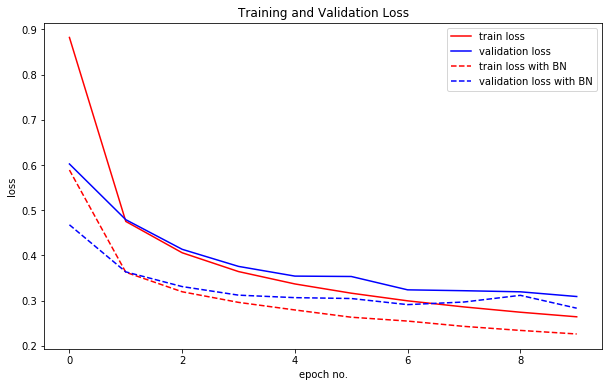

In [15]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, 'r', label="train loss")
plt.plot(x, epoch_test_loss, 'b', label="validation loss")

plt.plot(x, epoch_train_loss_bn, 'r--', label="train loss with BN")
plt.plot(x, epoch_test_loss_bn, 'b--',label="validation loss with BN")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see from the above curves that when we use Batch Normalization, the training converges much faster.

In [ ]:
x